# 畳み込みニューラルネット 多クラス分類
## インポート

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import cv2
from sklearn.model_selection import KFold
from bayes_opt import BayesianOptimization
import copy

print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

True


## 変数、クラス定義

In [2]:
directory_path = "D:/Work/ImageRecognition/Images/%s"
food_path = "food_142/"
flower_path = "flower_142/"
art_path = "art_142/"
balloon_path = "balloon_142/"
food_test_path = "food_test/"
flower_test_path = "flower_test/"
art_test_path = "art_test/"
balloon_test_path = "balloon_test/"

#画像の前処理を定義
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # ランダムにトリミングして (224, 224)の形状にしてる
        transforms.RandomHorizontalFlip(),  # 50%の確率で水平方向に反転させる
        transforms.ToTensor(),  # Tensorに変換
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 平均値と標準偏差を指定して、結果のTensorを正規化
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),  # 画像のサイズを(256, 256)にする
        transforms.CenterCrop(224),  # (224, 224)にするために、サイズ変更された画像を中央で切り取る
        transforms.ToTensor(),  # Tensorに変換
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # 平均値と標準偏差を指定して、結果のTensorを正規化
    ]),
}
#正規化をしない前処理
to_tensor_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])



class MultiClassDataset(torch.utils.data.Dataset):

    def __init__(self, contents=["fo", "fl"], transform=None, train=True):
        self.transform = transform
        self.images = []
        self.labels = []
        self.contents_label = []
        for i, c in enumerate(contents):
            if train:
                if c == "fo" or c == "food":
                    folder = directory_path%(food_path)
                elif c == "fl" or c == "flower":
                    folder = directory_path%(flower_path)
                elif c == "a" or c == "art":
                    folder = directory_path%(art_path)
                elif c == "b" or c == "balloon":
                    folder = directory_path%(balloon_path)
                else:
                    raise ValueError(f"{c} は間違った入力です")
            else:
                if c == "fo" or c == "food":
                    folder = directory_path%(food_test_path)
                elif c == "fl" or c == "flower":
                    folder = directory_path%(flower_test_path)
                elif c == "a" or c == "art":
                    folder = directory_path%(art_test_path)
                elif c == "b" or c == "balloon":
                    folder = directory_path%(balloon_test_path)
                else:
                    raise ValueError(f"{c} は間違った入力です")
            self.images.extend([folder + p for p in os.listdir(folder)])
            self.labels.extend([i] * (len(self.images)-len(self.labels)))
            self.contents_label.append(c)
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        with open(image, "rb") as f:
            image = Image.open(f)
            image = image.convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.images)
    
    def get_label_names(self):
        return self.contents_label

class ArtFoodFlowerDataset(torch.utils.data.Dataset):

    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.images = []
        self.labels = []
        if train:
            food_folder = directory_path%(food_path)
            flower_folder = directory_path%(flower_path)
            art_folder = directory_path%(art_path)
        else:
            food_folder = directory_path%(food_test_path)
            flower_folder = directory_path%(flower_test_path)
            art_folder = directory_path%(art_test_path)
        self.images.extend([food_folder + p for p in os.listdir(food_folder)])
        self.labels.extend([0] * len(self.images))
        self.images.extend([flower_folder + p for p in os.listdir(flower_folder)])
        self.labels.extend([1] * (len(self.images)-len(self.labels)))
        self.images.extend([art_folder + p for p in os.listdir(art_folder)])
        self.labels.extend([2] * (len(self.images)-len(self.labels)))
        
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        with open(image, "rb") as f:
            image = Image.open(f)
            image = image.convert("RGB")
        if self.transform is not None:
            image = self.transform(image)
        return image, label
        
    def __len__(self):
        return len(self.images)


class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        size_check = torch.FloatTensor(10, 3, 224, 224)
        fc_size = self.features(size_check).view(size_check.size(0), -1).size()[1]
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(fc_size, 4096), 
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## AlexNet Adam

['fo', 'fl']
Epoch [1/150], Loss: 0.0353, val_loss: 0.0711, val_acc: 0.4706
Epoch [2/150], Loss: 0.0342, val_loss: 0.0604, val_acc: 0.6471
Epoch [3/150], Loss: 0.0320, val_loss: 0.0556, val_acc: 0.7794
Epoch [4/150], Loss: 0.0260, val_loss: 0.0514, val_acc: 0.7647
Epoch [5/150], Loss: 0.0260, val_loss: 0.0569, val_acc: 0.7059
Epoch [6/150], Loss: 0.0260, val_loss: 0.0485, val_acc: 0.7059
Epoch [7/150], Loss: 0.0192, val_loss: 0.0476, val_acc: 0.7794
Epoch [8/150], Loss: 0.0152, val_loss: 0.0559, val_acc: 0.7500
Epoch [9/150], Loss: 0.0255, val_loss: 0.0580, val_acc: 0.6765
Epoch [10/150], Loss: 0.0268, val_loss: 0.0562, val_acc: 0.6618
Epoch [11/150], Loss: 0.0228, val_loss: 0.0660, val_acc: 0.7059
Epoch [12/150], Loss: 0.0224, val_loss: 0.0396, val_acc: 0.7941
Epoch [13/150], Loss: 0.0214, val_loss: 0.0417, val_acc: 0.8088
Epoch [14/150], Loss: 0.0234, val_loss: 0.0449, val_acc: 0.8235
Epoch [15/150], Loss: 0.0235, val_loss: 0.0493, val_acc: 0.7647
Epoch [16/150], Loss: 0.0191, val_lo

Epoch [129/150], Loss: 0.0049, val_loss: 0.0450, val_acc: 0.8971
Epoch [130/150], Loss: 0.0071, val_loss: 0.0215, val_acc: 0.8971
Epoch [131/150], Loss: 0.0058, val_loss: 0.0542, val_acc: 0.9118
Epoch [132/150], Loss: 0.0053, val_loss: 0.0354, val_acc: 0.8971
Epoch [133/150], Loss: 0.0075, val_loss: 0.0323, val_acc: 0.9265
Epoch [134/150], Loss: 0.0072, val_loss: 0.0359, val_acc: 0.8824
Epoch [135/150], Loss: 0.0047, val_loss: 0.0271, val_acc: 0.9118
Epoch [136/150], Loss: 0.0057, val_loss: 0.0344, val_acc: 0.9118
Epoch [137/150], Loss: 0.0074, val_loss: 0.0318, val_acc: 0.8971
Epoch [138/150], Loss: 0.0104, val_loss: 0.0370, val_acc: 0.8529
Epoch [139/150], Loss: 0.0081, val_loss: 0.0385, val_acc: 0.8235
Epoch [140/150], Loss: 0.0075, val_loss: 0.0420, val_acc: 0.8529
Epoch [141/150], Loss: 0.0044, val_loss: 0.0352, val_acc: 0.9118
Epoch [142/150], Loss: 0.0109, val_loss: 0.0356, val_acc: 0.8824
Epoch [143/150], Loss: 0.0068, val_loss: 0.0396, val_acc: 0.8824
Epoch [144/150], Loss: 0.

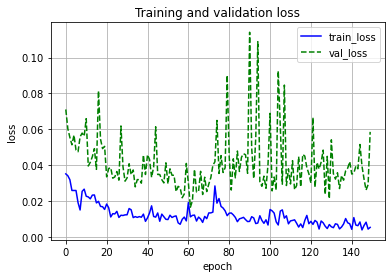

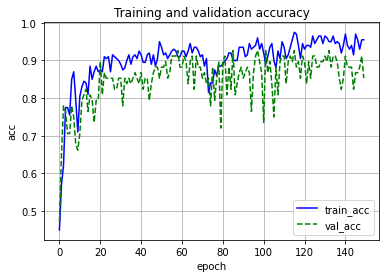

In [6]:
# 定義したDatasetとDataLoaderを使用
test_contents = ["fo", "fl"]
train_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=20, 
                                           shuffle=True)
valuation_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["val"], train=False)
valuation_loader = torch.utils.data.DataLoader(dataset=valuation_dataset,
                                           batch_size=10, 
                                           shuffle=False)

num_classes = len(train_dataset.get_label_names())
print(train_dataset.get_label_names())


net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005, eps=3E-09)

num_epochs = 150

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
      
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    net.eval()
    with torch.no_grad():
        for images, labels in valuation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(valuation_loader.dataset)
    avg_val_acc = val_acc / len(valuation_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## 4クラス (fo fl a b)
Epoch [150/150], Loss: 0.0159, val_loss: 0.1424, val_acc: 0.7365
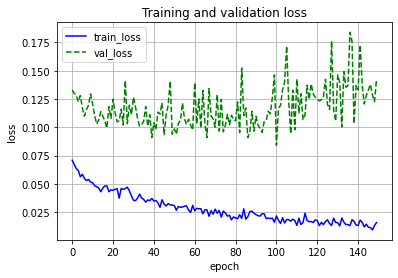

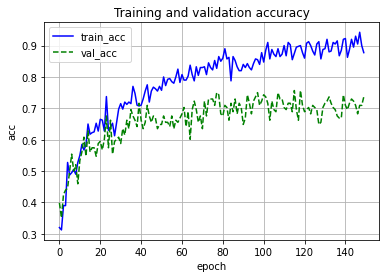

## 3クラス（fo fl a）
Epoch [150/150], Loss: 0.0129, val_loss: 0.0425, val_acc: 0.7547
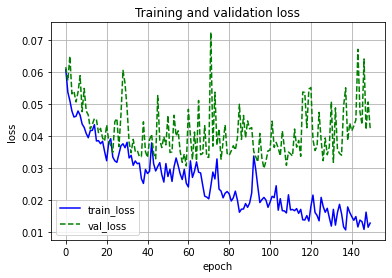

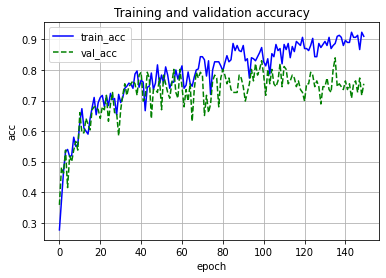

## 2クラス (fo fl)
Epoch [150/150], Loss: 0.0055, val_loss: 0.0586, val_acc: 0.8529
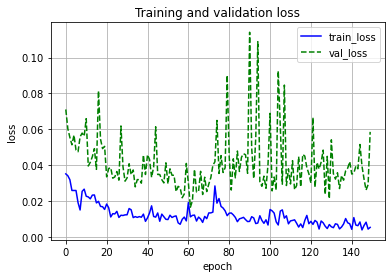

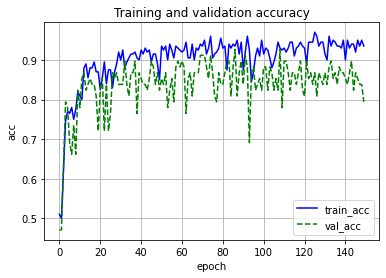

## AlexNet Momentum

['fo', 'fl', 'a', 'b']
Epoch [1/300], Loss: 0.0693, val_loss: 0.1405, val_acc: 0.3649
Epoch [2/300], Loss: 0.0693, val_loss: 0.1405, val_acc: 0.2432
Epoch [3/300], Loss: 0.0694, val_loss: 0.1403, val_acc: 0.2568
Epoch [4/300], Loss: 0.0692, val_loss: 0.1401, val_acc: 0.3649
Epoch [5/300], Loss: 0.0689, val_loss: 0.1384, val_acc: 0.3514
Epoch [6/300], Loss: 0.0674, val_loss: 0.1349, val_acc: 0.3716
Epoch [7/300], Loss: 0.0657, val_loss: 0.1399, val_acc: 0.3716
Epoch [8/300], Loss: 0.0624, val_loss: 0.1298, val_acc: 0.4122
Epoch [9/300], Loss: 0.0628, val_loss: 0.1318, val_acc: 0.3581
Epoch [10/300], Loss: 0.0647, val_loss: 0.1273, val_acc: 0.4257
Epoch [11/300], Loss: 0.0606, val_loss: 0.1357, val_acc: 0.3581
Epoch [12/300], Loss: 0.0594, val_loss: 0.1229, val_acc: 0.4189
Epoch [13/300], Loss: 0.0575, val_loss: 0.1415, val_acc: 0.4257
Epoch [14/300], Loss: 0.0596, val_loss: 0.1184, val_acc: 0.4932
Epoch [15/300], Loss: 0.0618, val_loss: 0.1299, val_acc: 0.4122
Epoch [16/300], Loss: 0.05

Epoch [129/300], Loss: 0.0241, val_loss: 0.0925, val_acc: 0.7027
Epoch [130/300], Loss: 0.0271, val_loss: 0.1069, val_acc: 0.6892
Epoch [131/300], Loss: 0.0199, val_loss: 0.0903, val_acc: 0.7432
Epoch [132/300], Loss: 0.0201, val_loss: 0.0965, val_acc: 0.7230
Epoch [133/300], Loss: 0.0193, val_loss: 0.0948, val_acc: 0.7432
Epoch [134/300], Loss: 0.0199, val_loss: 0.0905, val_acc: 0.7297
Epoch [135/300], Loss: 0.0195, val_loss: 0.1033, val_acc: 0.7027
Epoch [136/300], Loss: 0.0164, val_loss: 0.1102, val_acc: 0.7568
Epoch [137/300], Loss: 0.0191, val_loss: 0.0798, val_acc: 0.7568
Epoch [138/300], Loss: 0.0167, val_loss: 0.1009, val_acc: 0.7230
Epoch [139/300], Loss: 0.0253, val_loss: 0.1048, val_acc: 0.6892
Epoch [140/300], Loss: 0.0232, val_loss: 0.0879, val_acc: 0.7095
Epoch [141/300], Loss: 0.0236, val_loss: 0.0990, val_acc: 0.7432
Epoch [142/300], Loss: 0.0224, val_loss: 0.1056, val_acc: 0.6892
Epoch [143/300], Loss: 0.0229, val_loss: 0.1029, val_acc: 0.7095
Epoch [144/300], Loss: 0.

Epoch [256/300], Loss: 0.0126, val_loss: 0.1139, val_acc: 0.7365
Epoch [257/300], Loss: 0.0095, val_loss: 0.0950, val_acc: 0.7432
Epoch [258/300], Loss: 0.0113, val_loss: 0.1119, val_acc: 0.7432
Epoch [259/300], Loss: 0.0087, val_loss: 0.1217, val_acc: 0.7365
Epoch [260/300], Loss: 0.0127, val_loss: 0.1067, val_acc: 0.7027
Epoch [261/300], Loss: 0.0124, val_loss: 0.1470, val_acc: 0.7095
Epoch [262/300], Loss: 0.0132, val_loss: 0.1019, val_acc: 0.7297
Epoch [263/300], Loss: 0.0171, val_loss: 0.0970, val_acc: 0.7027
Epoch [264/300], Loss: 0.0159, val_loss: 0.0834, val_acc: 0.6959
Epoch [265/300], Loss: 0.0097, val_loss: 0.0872, val_acc: 0.7432
Epoch [266/300], Loss: 0.0125, val_loss: 0.1412, val_acc: 0.6554
Epoch [267/300], Loss: 0.0198, val_loss: 0.1071, val_acc: 0.6689
Epoch [268/300], Loss: 0.0140, val_loss: 0.1203, val_acc: 0.6892
Epoch [269/300], Loss: 0.0136, val_loss: 0.1084, val_acc: 0.7162
Epoch [270/300], Loss: 0.0160, val_loss: 0.0902, val_acc: 0.7500
Epoch [271/300], Loss: 0.

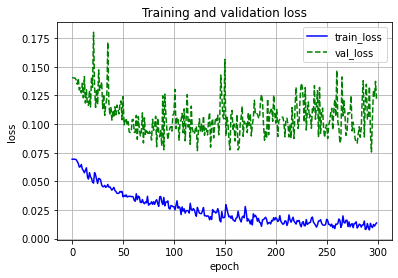

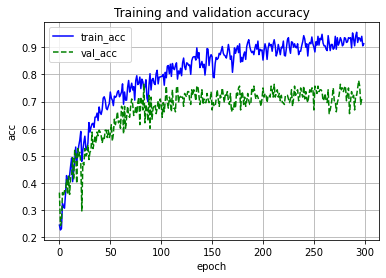

In [9]:
test_contents = ["fo", "fl", "a", "b"]
train_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=20, 
                                           shuffle=True)
valuation_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["val"], train=False)
valuation_loader = torch.utils.data.DataLoader(dataset=valuation_dataset,
                                           batch_size=10, 
                                           shuffle=False)

num_classes = len(train_dataset.get_label_names())
print(train_dataset.get_label_names())


net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

num_epochs = 300

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    net.eval()
    with torch.no_grad():
        for images, labels in valuation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(valuation_loader.dataset)
    avg_val_acc = val_acc / len(valuation_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

## 4クラス分類 (fo fl a b)
Epoch [300/300], Loss: 0.0136, val_loss: 0.1215, val_acc: 0.7095
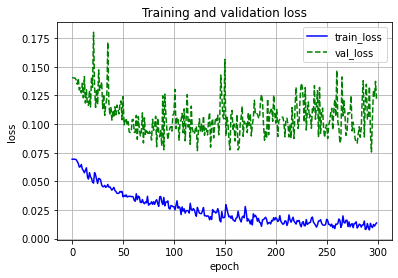

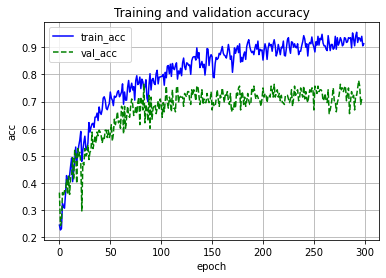

## 3クラス分類 (fo fl a)
Epoch [300/300], Loss: 0.0086, val_loss: 0.0812, val_acc: 0.7830
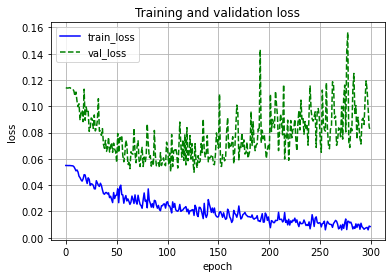

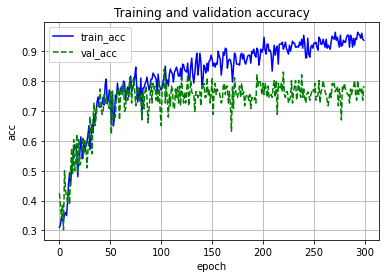

## 2クラス分類 (fo fl)
Epoch [300/300], Loss: 0.0029, val_loss: 0.0540, val_acc: 0.8529
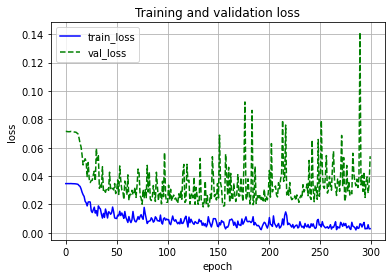

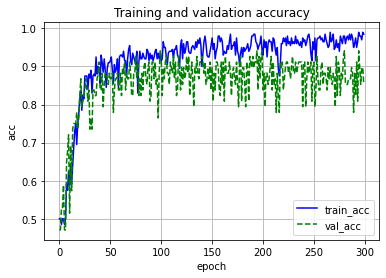

## ハイパーパラメータ探索　ベイズ最適化

### Adam

In [11]:
test_contents = ["fo", "fl", "a", "b"]
train_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=20, 
                                           shuffle=True)
valuation_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["val"], train=False)
valuation_loader = torch.utils.data.DataLoader(dataset=valuation_dataset,
                                           batch_size=10, 
                                           shuffle=False)

num_classes = len(train_dataset.get_label_names())
print(train_dataset.get_label_names())

net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()

num_epochs = 150


['fo', 'fl', 'a', 'b']


In [12]:
def optimize_alex(train_dataloader, valuation_dataloader):
    
    def model_alex_negative_loss(lr, beta1, eps):
        loss_nan_count = 0
        net = AlexNet(num_classes).to(device)
        optimizer = optim.Adam(net.parameters(), lr=lr, betas=(beta1, 0.999), eps=eps)
        net.train()
        for epoch in range(num_epochs):
            train_loss = 0
            train_acc = 0

            for images, labels in train_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                if torch.isnan(loss):
#                     net = prev_net
#                     optimizer = torch.optim.Adam(net.parameters())
#                     optimizer.load_state_dict(prev_optimizer.state_dict())
                    loss_nan_count += 1
                else:
#                     prev_net = copy.copy(net)
#                     prev_optimizer = copy.copy(optimizer)
                    optimizer.zero_grad()
                    train_loss += loss.item()
                    train_acc += (outputs.max(1)[1] == labels).sum().item()
                    loss.backward()
                    optimizer.step()
        
#         print(f"train nan count {loss_nan_count}")
        loss_nan_count = 0
        net.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            
            for images, labels in valuation_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                if torch.isnan(loss):
                    loss_nan_count += 1
                else:
                    val_loss += loss.item()
                    val_acc += (outputs.max(1)[1] == labels).sum().item()
                    
#         print(f"test nan count {loss_nan_count}")
        #print("val_loss: {}, n: {}, avg_loss: {}".format(val_loss, len(valuation_dataloader.dataset), val_loss / len(valuation_dataloader.dataset)))
        
        if np.isnan(val_loss):
            raise UnboundLocalError("クラス、データローダを定義してください")
        avg_val_loss = val_loss / (len(valuation_dataloader.dataset) - loss_nan_count)
        avg_val_acc = val_acc / (len(valuation_dataloader.dataset) - loss_nan_count)
        
        return avg_val_acc
    
    hyperparam_optimizer = BayesianOptimization(
        f=model_alex_negative_loss,
        pbounds={
            "lr": (5e-05, 3e-04),
            "beta1": (0.04, 0.053),
            "eps": (3e-07, 5e-07),
        }
    )
    
    hyperparam_optimizer.maximize(init_points=10, n_iter=0)
    print("Final result:", hyperparam_optimizer.max)
    for i, res in enumerate(hyperparam_optimizer.res):
        print(res["params"]["eps"])

optimize_alex(train_loader, valuation_loader)

|   iter    |  target   |   beta1   |    eps    |    lr     |
-------------------------------------------------------------
|  1        |  0.723    |  0.0516   |  2.531e-0 |  0.000108 |
|  2        |  0.7162   |  0.04153  |  1.458e-0 |  0.000276 |
|  3        |  0.7568   |  0.04442  |  3.179e-0 |  0.000291 |
|  4        |  0.7027   |  0.04955  |  2.311e-0 |  8.383e-0 |
|  5        |  0.7432   |  0.04339  |  1.744e-0 |  0.000210 |
|  6        |  0.6419   |  0.04448  |  3.345e-0 |  0.000226 |
|  7        |  0.6959   |  0.0441   |  2.943e-0 |  0.000119 |
|  8        |  0.7635   |  0.04431  |  4.45e-07 |  0.000106 |
|  9        |  0.7095   |  0.04904  |  2.152e-0 |  0.000107 |
|  10       |  0.75     |  0.05105  |  3.596e-0 |  9.434e-0 |
Final result: {'target': 0.7635135135135135, 'params': {'beta1': 0.04430673020659635, 'eps': 4.4500120415692874e-07, 'lr': 0.00010603404146978507}}
2.5307858606680564e-07
1.4581309989664327e-07
3.178973895023028e-07
2.3108435803515516e-07
1.744045860652657

#### 3クラス (fo fl a) ハイパーパラメータ

|   iter    |  target   |   beta1   |    eps    |    lr     |
|-----------|-----------|-----------|-----------|------------|
|  1        |  0.6981   |  0.05812  |  4.501e-07 |  0.000216 |
|  2        |  0.7925   |  0.05251  |  1.156e-07 |  8.677e-0 |
|  3        |  0.7642   |  0.04631  |  1.949e-07 |  0.000101 |
|  **4**        |  **0.8019**   |  **0.04726**  |  **4.05e-07** |  **0.000293** |
|  5        |  0.6509   |  0.05759  |  3.047e-07 |  6.752e-0 |
|  6        |  0.783    |  0.04855  |  3.07e-07 |  5.233e-0 |
|  7        |  0.7453   |  0.05521  |  4.875e-07 |  0.000214 |
|  8        |  0.7736   |  0.05731  |  4.448e-08 |  0.000199 |
|  9        |  0.7736   |  0.05872  |  9.724e-07 |  0.000222 |
|  10       |  0.7736   |  0.05256  |  4.226e-0 |  0.000298 |

Final result: {'target': 0.8018867924528302, 'params': {'beta1': 0.047256218940738136, 'eps': 4.0495074675263074e-07, 'lr': 0.0002934521400457012}}

#### 4クラス (fo fl a b) ハイパーパラメータ

|   iter    |  target   |   beta1   |    eps    |    lr     |
|-----------|-----------|-----------|-----------|-------------|
|  1        |  0.723    |  0.0516   |  2.531e-0 |  0.000108 |
|  2        |  0.7162   |  0.04153  |  1.458e-0 |  0.000276 |
|  3        |  0.7568   |  0.04442  |  3.179e-0 |  0.000291 |
|  4        |  0.7027   |  0.04955  |  2.311e-0 |  8.383e-0 |
|  5        |  0.7432   |  0.04339  |  1.744e-0 |  0.000210 |
|  6        |  0.6419   |  0.04448  |  3.345e-0 |  0.000226 |
|  7        |  0.6959   |  0.0441   |  2.943e-0 |  0.000119 |
|**8**        |  **0.7635**   |  **0.04431**  |  **4.45e-07** | **0.000106** |
|  9        |  0.7095   |  0.04904  |  2.152e-0 |  0.000107 |
|  10       |  0.75     |  0.05105  |  3.596e-0 |  9.434e-0 |

Final result: {'target': 0.7635135135135135, 'params': {'beta1': 0.04430673020659635, 'eps': 4.4500120415692874e-07, 'lr': 0.00010603404146978507}}

### ハイパーパラメータのテスト

Epoch [1/150], Loss: 0.0689, val_loss: 0.1570, val_acc: 0.2230
Epoch [2/150], Loss: 0.0755, val_loss: 0.1372, val_acc: 0.3784
Epoch [3/150], Loss: 0.0694, val_loss: 0.1320, val_acc: 0.4865
Epoch [4/150], Loss: 0.0617, val_loss: 0.1195, val_acc: 0.4662
Epoch [5/150], Loss: 0.0632, val_loss: 0.1292, val_acc: 0.3514
Epoch [6/150], Loss: 0.0673, val_loss: 0.1228, val_acc: 0.4257
Epoch [7/150], Loss: 0.0605, val_loss: 0.1252, val_acc: 0.4527
Epoch [8/150], Loss: 0.0575, val_loss: 0.1181, val_acc: 0.5203
Epoch [9/150], Loss: 0.0543, val_loss: 0.1161, val_acc: 0.5338
Epoch [10/150], Loss: 0.0533, val_loss: 0.1516, val_acc: 0.4797
Epoch [11/150], Loss: 0.0527, val_loss: 0.1166, val_acc: 0.4459
Epoch [12/150], Loss: 0.0493, val_loss: 0.1042, val_acc: 0.5676
Epoch [13/150], Loss: 0.0470, val_loss: 0.1094, val_acc: 0.5878
Epoch [14/150], Loss: 0.0489, val_loss: 0.1062, val_acc: 0.5405
Epoch [15/150], Loss: 0.0474, val_loss: 0.1057, val_acc: 0.5473
Epoch [16/150], Loss: 0.0493, val_loss: 0.1148, v

Epoch [129/150], Loss: 0.0136, val_loss: 0.1144, val_acc: 0.7365
Epoch [130/150], Loss: 0.0135, val_loss: 0.1125, val_acc: 0.6959
Epoch [131/150], Loss: 0.0107, val_loss: 0.1330, val_acc: 0.7162
Epoch [132/150], Loss: 0.0146, val_loss: 0.1251, val_acc: 0.7095
Epoch [133/150], Loss: 0.0114, val_loss: 0.1135, val_acc: 0.7500
Epoch [134/150], Loss: 0.0075, val_loss: 0.1574, val_acc: 0.7162
Epoch [135/150], Loss: 0.0102, val_loss: 0.1180, val_acc: 0.7500
Epoch [136/150], Loss: 0.0153, val_loss: 0.1223, val_acc: 0.7230
Epoch [137/150], Loss: 0.0101, val_loss: 0.1196, val_acc: 0.7365
Epoch [138/150], Loss: 0.0119, val_loss: 0.1066, val_acc: 0.7635
Epoch [139/150], Loss: 0.0093, val_loss: 0.1244, val_acc: 0.7297
Epoch [140/150], Loss: 0.0140, val_loss: 0.1098, val_acc: 0.7095
Epoch [141/150], Loss: 0.0106, val_loss: 0.1348, val_acc: 0.6892
Epoch [142/150], Loss: 0.0098, val_loss: 0.1198, val_acc: 0.7297
Epoch [143/150], Loss: 0.0126, val_loss: 0.1176, val_acc: 0.7027
Epoch [144/150], Loss: 0.

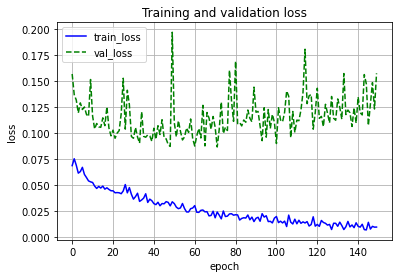

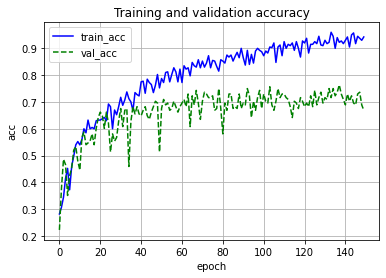

In [13]:
net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0002, betas=(0.045, 0.999), eps=4.2e-07)

num_epochs = 150
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    net.train()
    for i, (images, labels) in enumerate(train_loader):
      images, labels = images.to(device), labels.to(device)
      
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      train_loss += loss.item()
      train_acc += (outputs.max(1)[1] == labels).sum().item()
      loss.backward()
      optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    net.eval()
    with torch.no_grad():
      for images, labels in valuation_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(valuation_loader.dataset)
    avg_val_acc = val_acc / len(valuation_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()

### Momentum

In [18]:
def optimize_momentum(train_dataloader, valuation_dataloader):
    
    def model_momentum_negative_loss(lr, momentum, weight_decay):
        loss_nan_count = 0
        net = AlexNet(num_classes).to(device)
        optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
        net.train()
        for epoch in range(num_epochs):
            train_loss = 0
            train_acc = 0

            for images, labels in train_dataloader:
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                if torch.isnan(loss):
#                     net = prev_net
#                     optimizer = torch.optim.Adam(net.parameters())
#                     optimizer.load_state_dict(prev_optimizer.state_dict())
                    loss_nan_count += 1
                else:
#                     prev_net = copy.copy(net)
#                     prev_optimizer = copy.copy(optimizer)
                    optimizer.zero_grad()
                    train_loss += loss.item()
                    train_acc += (outputs.max(1)[1] == labels).sum().item()
                    loss.backward()
                    optimizer.step()
        
#         print(f"train nan count {loss_nan_count}")
        loss_nan_count = 0
        net.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            
            for images, labels in valuation_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = net(images)
                loss = criterion(outputs, labels)
                if torch.isnan(loss):
                    loss_nan_count += 1
                else:
                    val_loss += loss.item()
                    val_acc += (outputs.max(1)[1] == labels).sum().item()
                    
#         print(f"test nan count {loss_nan_count}")
        #print("val_loss: {}, n: {}, avg_loss: {}".format(val_loss, len(valuation_dataloader.dataset), val_loss / len(valuation_dataloader.dataset)))
        
        if np.isnan(val_loss):
            raise UnboundLocalError("クラス、データローダを定義してください")
        avg_val_loss = val_loss / (len(valuation_dataloader.dataset) - loss_nan_count)
        avg_val_acc = val_acc / (len(valuation_dataloader.dataset) - loss_nan_count)
        
        return avg_val_acc
    
    hyperparam_optimizer = BayesianOptimization(
        f=model_momentum_negative_loss,
        pbounds={
            "lr": (0.005, 0.05),
            "momentum": (0.5, 0.9),
            "weight_decay": (5e-5, 2e-3),
        }
    )
    
    hyperparam_optimizer.maximize(init_points=10, n_iter=0)
    print("Final result:", hyperparam_optimizer.max)

optimize_momentum(train_loader, valuation_loader)

|   iter    |  target   |    lr     | momentum  | weight... |
-------------------------------------------------------------
|  1        |  0.6892   |  0.02325  |  0.8646   |  0.001744 |
|  2        |  0.7027   |  0.04243  |  0.705    |  0.001773 |
|  3        |  0.6689   |  0.006576 |  0.6773   |  0.000556 |
|  4        |  0.7095   |  0.02316  |  0.6455   |  0.001716 |
|  5        |  0.7095   |  0.016    |  0.5679   |  0.001163 |
|  6        |  0.6689   |  0.03473  |  0.7223   |  0.000864 |
|  7        |  0.7635   |  0.011    |  0.633    |  0.000275 |
|  8        |  0.7365   |  0.007703 |  0.5251   |  7.541e-0 |
|  9        |  0.6554   |  0.04954  |  0.6591   |  0.000754 |
|  10       |  0.7635   |  0.005214 |  0.7947   |  0.001104 |
Final result: {'target': 0.7635135135135135, 'params': {'lr': 0.01099916718201583, 'momentum': 0.6330480072165683, 'weight_decay': 0.00027525537843078987}}


### 4クラス　ハイパーパラメータ

|   iter    |  target   |    lr     | momentum  | weight... |
|-----------|-----------|-----------|-----------|-----------|
|  1        |  0.6892   |  0.02325  |  0.8646   |  0.001744 |
|  2        |  0.7027   |  0.04243  |  0.705    |  0.001773 |
|  3        |  0.6689   |  0.006576 |  0.6773   |  0.000556 |
|  4        |  0.7095   |  0.02316  |  0.6455   |  0.001716 |
|  5        |  0.7095   |  0.016    |  0.5679   |  0.001163 |
|  6        |  0.6689   |  0.03473  |  0.7223   |  0.000864 |
|  7        |  0.7635   |  0.011    |  0.633    |  0.000275 |
|  8        |  0.7365   |  0.007703 |  0.5251   |  7.541e-0 |
|  9        |  0.6554   |  0.04954  |  0.6591   |  0.000754 |
|  10       |  0.7635   |  0.005214 |  0.7947   |  0.001104 |

Final result: {'target': 0.7635135135135135, 'params': {'lr': 0.01099916718201583, 'momentum': 0.6330480072165683, 'weight_decay': 0.00027525537843078987}}

['fo', 'fl', 'a', 'b']
Epoch [1/300], Loss: 0.0693, val_loss: 0.1405, val_acc: 0.2635
Epoch [2/300], Loss: 0.0693, val_loss: 0.1405, val_acc: 0.2432
Epoch [3/300], Loss: 0.0693, val_loss: 0.1405, val_acc: 0.2297
Epoch [4/300], Loss: 0.0693, val_loss: 0.1405, val_acc: 0.2365
Epoch [5/300], Loss: 0.0693, val_loss: 0.1405, val_acc: 0.2973
Epoch [6/300], Loss: 0.0693, val_loss: 0.1404, val_acc: 0.2365
Epoch [7/300], Loss: 0.0693, val_loss: 0.1403, val_acc: 0.4122
Epoch [8/300], Loss: 0.0692, val_loss: 0.1403, val_acc: 0.3986
Epoch [9/300], Loss: 0.0692, val_loss: 0.1402, val_acc: 0.3176
Epoch [10/300], Loss: 0.0692, val_loss: 0.1401, val_acc: 0.3514
Epoch [11/300], Loss: 0.0691, val_loss: 0.1400, val_acc: 0.3041
Epoch [12/300], Loss: 0.0690, val_loss: 0.1398, val_acc: 0.3378
Epoch [13/300], Loss: 0.0687, val_loss: 0.1395, val_acc: 0.3176
Epoch [14/300], Loss: 0.0685, val_loss: 0.1389, val_acc: 0.3108
Epoch [15/300], Loss: 0.0677, val_loss: 0.1379, val_acc: 0.3176
Epoch [16/300], Loss: 0.06

Epoch [129/300], Loss: 0.0265, val_loss: 0.1170, val_acc: 0.6959
Epoch [130/300], Loss: 0.0248, val_loss: 0.0982, val_acc: 0.7230
Epoch [131/300], Loss: 0.0269, val_loss: 0.0915, val_acc: 0.7027
Epoch [132/300], Loss: 0.0249, val_loss: 0.0952, val_acc: 0.7027
Epoch [133/300], Loss: 0.0305, val_loss: 0.0997, val_acc: 0.6824
Epoch [134/300], Loss: 0.0262, val_loss: 0.0879, val_acc: 0.7432
Epoch [135/300], Loss: 0.0231, val_loss: 0.1260, val_acc: 0.6554
Epoch [136/300], Loss: 0.0250, val_loss: 0.0876, val_acc: 0.7162
Epoch [137/300], Loss: 0.0257, val_loss: 0.0834, val_acc: 0.7703
Epoch [138/300], Loss: 0.0226, val_loss: 0.0876, val_acc: 0.7297
Epoch [139/300], Loss: 0.0254, val_loss: 0.0829, val_acc: 0.7297
Epoch [140/300], Loss: 0.0245, val_loss: 0.1478, val_acc: 0.6554
Epoch [141/300], Loss: 0.0276, val_loss: 0.0796, val_acc: 0.7230
Epoch [142/300], Loss: 0.0260, val_loss: 0.0823, val_acc: 0.7365
Epoch [143/300], Loss: 0.0232, val_loss: 0.0831, val_acc: 0.7365
Epoch [144/300], Loss: 0.

Epoch [256/300], Loss: 0.0145, val_loss: 0.1666, val_acc: 0.6216
Epoch [257/300], Loss: 0.0175, val_loss: 0.1065, val_acc: 0.7432
Epoch [258/300], Loss: 0.0125, val_loss: 0.1217, val_acc: 0.7162
Epoch [259/300], Loss: 0.0122, val_loss: 0.1062, val_acc: 0.7365
Epoch [260/300], Loss: 0.0119, val_loss: 0.1033, val_acc: 0.7500
Epoch [261/300], Loss: 0.0115, val_loss: 0.1153, val_acc: 0.7365
Epoch [262/300], Loss: 0.0141, val_loss: 0.0990, val_acc: 0.7365
Epoch [263/300], Loss: 0.0117, val_loss: 0.1118, val_acc: 0.7500
Epoch [264/300], Loss: 0.0113, val_loss: 0.1124, val_acc: 0.7635
Epoch [265/300], Loss: 0.0082, val_loss: 0.1269, val_acc: 0.6892
Epoch [266/300], Loss: 0.0120, val_loss: 0.1313, val_acc: 0.6959
Epoch [267/300], Loss: 0.0102, val_loss: 0.1124, val_acc: 0.7500
Epoch [268/300], Loss: 0.0102, val_loss: 0.1110, val_acc: 0.7703
Epoch [269/300], Loss: 0.0165, val_loss: 0.1021, val_acc: 0.7365
Epoch [270/300], Loss: 0.0122, val_loss: 0.0946, val_acc: 0.7432
Epoch [271/300], Loss: 0.

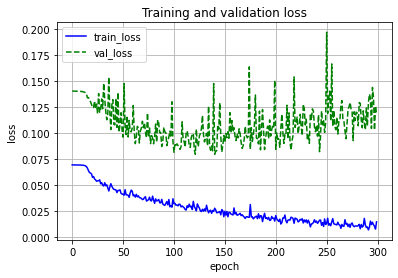

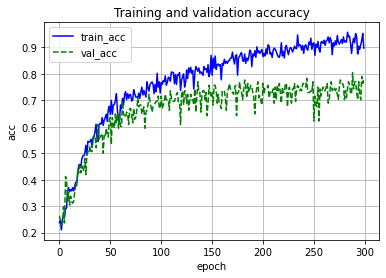

In [19]:
test_contents = ["fo", "fl", "a", "b"]
train_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["train"], train=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=20, 
                                           shuffle=True)
valuation_dataset = MultiClassDataset(contents=test_contents, transform=data_transforms["val"], train=False)
valuation_loader = torch.utils.data.DataLoader(dataset=valuation_dataset,
                                           batch_size=10, 
                                           shuffle=False)

num_classes = len(train_dataset.get_label_names())
print(train_dataset.get_label_names())


net = AlexNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.63, weight_decay=0.000275)

num_epochs = 300

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    net.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    net.eval()
    with torch.no_grad():
        for images, labels in valuation_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
    avg_val_loss = val_loss / len(valuation_loader.dataset)
    avg_val_acc = val_acc / len(valuation_loader.dataset)

    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()